# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.263813,True,6.285923
1,-0.328853,False,-1.866068
2,-0.772875,False,-1.049072
3,0.359333,False,0.619850
4,-0.224268,False,0.726124
...,...,...,...
995,-0.906986,False,-0.952984
996,-0.809251,True,3.329172
997,-1.757487,False,-3.550598
998,-0.719413,False,-1.864781


<Axes: xlabel='v0'>

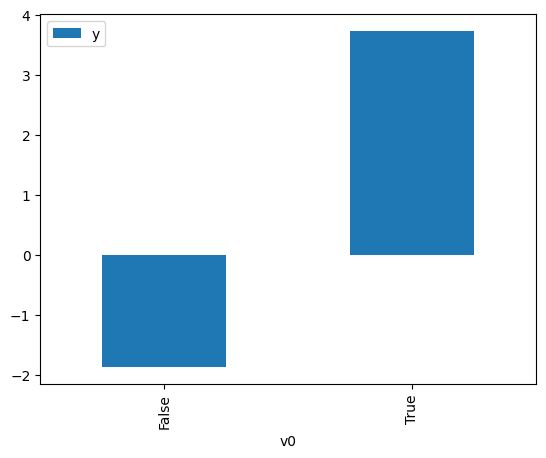

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

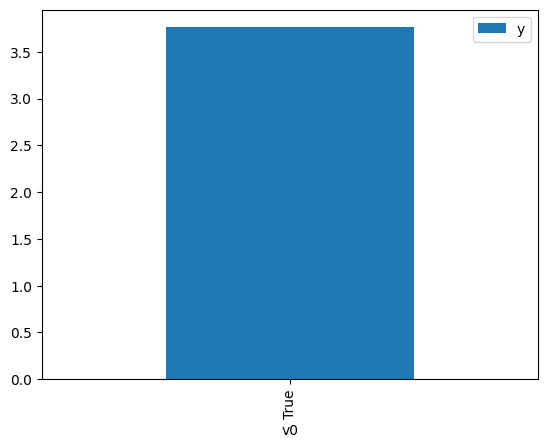

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-1.757807,False,-3.010976,0.987995,1.012151
1,-0.866473,False,-2.186977,0.900354,1.110674
2,-1.858548,False,-3.942142,0.990623,1.009466
3,-0.740583,False,-1.892511,0.868659,1.151200
4,-1.745268,False,-3.910923,0.987621,1.012535
...,...,...,...,...,...
995,-0.657671,False,-1.874827,0.843387,1.185695
996,-0.794280,False,-2.126688,0.883112,1.132359
997,-0.221608,False,-0.657293,0.646312,1.547239
998,-1.105091,False,-2.115664,0.942274,1.061263


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.050783,True,2.731076,0.065499,15.267465
1,-0.985130,True,1.788999,0.076191,13.124875
2,-0.108416,True,4.695585,0.420110,2.380329
3,-0.687421,True,4.199729,0.147118,6.797267
4,-0.088429,True,5.386992,0.432224,2.313616
...,...,...,...,...,...
995,-1.434368,True,1.528782,0.026373,37.917899
996,-0.689510,True,3.494614,0.146469,6.827374
997,-0.080110,True,4.474811,0.437290,2.286810
998,-1.142451,True,3.025472,0.052891,18.906792


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                              7311.
Date:                Wed, 27 Sep 2023   Prob (F-statistic):                        0.00
Time:                        18:45:02   Log-Likelihood:                         -1426.8
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2867.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0065      0.025     78.981      0.000       1.957       2.056
x2             5.0168      0.062     80.567      0.000       4.895       5.139
==============================================================================
Omnibus:                        0.054   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.974   Jarque-Bera (JB):                0.030
Skew:                          -0.013   Prob(JB):                        0.985
Kurtosis:                       3.007   Cond. No.                         2.48
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""